In [2]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import category_encoders as ce
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

### Working with Weather Data

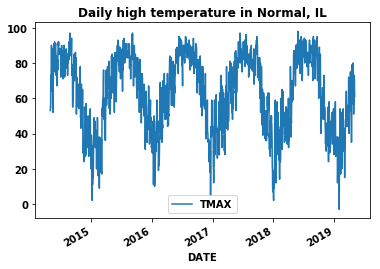

In [3]:
url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-3-Classification-Validation/master/module2-baselines-validation/weather-normal-il.csv'
weather = pd.read_csv(url, parse_dates=['DATE']).set_index('DATE')
weather['2014-05':'2019-05'].plot(y='TMAX')
plt.title('Daily high temperature in Normal, IL');

In [4]:
# Calc mean of TMAX
weather['TMAX'].mean()

62.51874226107839

In [5]:
# calc mean absolute error if we use the mean as the daily temp
# prediction for a year
predicted = [weather['TMAX'].mean()] * len(weather)
mean_absolute_error(weather['TMAX'], predicted)

18.687693151466384

**Our baseline model is off by 18 degrees**

### Improving our model

In [6]:
# Now we predict tomorrow's weather is going to be whatever it was
# today

# shift(1) pushed the index forward by 1, which creates the lag needed
# to create yesterday's weather
weather['TMAX_yesterday'] = weather.TMAX.shift(1)

# we then drop the first date because it doesn't have a "yesterday"
weather = weather.dropna()
mean_absolute_error(weather.TMAX, weather.TMAX_yesterday)

5.53609756097561

### Bank Marketing - majority class baseline

In [51]:
bank = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [8]:
# separate target and features
X = bank.drop(columns='y')
y = bank['y'] == 'yes'

### 3-way split: Train / Validation / Test

In [9]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Create a second split using only the train data to create the
# validation set and new train set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [11]:
# verifying the shape of the splits
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((23065, 20), (9885, 20), (8238, 20), (23065,), (9885,), (8238,))

### Majority class baseline

In [12]:
y_train.value_counts(normalize=True)

False    0.887362
True     0.112638
Name: y, dtype: float64

In [13]:
# What if we guessed the majority class for every prediction
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_val)

# accuracy score
print('Accuracy Score:', accuracy_score(y_val, y_pred))
print('ROC AUC Score:', roc_auc_score(y_val, y_pred))

Accuracy Score: 0.8873039959534649
ROC AUC Score: 0.5


# Fast First Models

In [14]:
# Ignore rows/columns with nulls
X_train.isnull().sum().sort_values()

age               0
cons.conf.idx     0
cons.price.idx    0
emp.var.rate      0
poutcome          0
previous          0
pdays             0
campaign          0
duration          0
day_of_week       0
month             0
contact           0
loan              0
housing           0
default           0
education         0
marital           0
job               0
euribor3m         0
nr.employed       0
dtype: int64

In [15]:
# features_not_null = X_train.notnull()

### Ignore non-numeric features

In [16]:
X_train.describe(include='number')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,23065.000000,23065.000000,23065.000000,23065.000000,23065.000000,23065.000000,23065.000000,23065.000000,23065.000000,23065.000000
mean,39.986343,257.834208,2.569391,961.977152,0.174767,0.087717,93.578786,-40.497490,3.624652,5167.049560
std,10.419539,260.598528,2.785993,188.130448,0.498633,1.568378,0.579648,4.627492,1.734725,72.602289
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [17]:
# Non-numeric features
X_train.describe(exclude='number')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,23065,23065,23065,23065,23065,23065,23065,23065,23065,23065
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,5792,14009,6819,18223,12092,18990,14626,7681,4801,19894


In [18]:
# Select all numeric features
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

### Shallow trees for a fast first baseline

In [19]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train_numeric, y_train)
y_pred_proba = tree.predict_proba(X_val_numeric)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.8647642682440316

### Looking for Leakage

In [20]:
# Let's drop the duration feature
X_train = X_train.drop(columns='duration')
X_val = X_val.drop(columns='duration')
X_test = X_test.drop(columns='duration')

X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

### Note:

- When the duration fature is dropped, then the ROC AUC score drops, which is what we expect. It's not a bad thing in this situation!

In [21]:
# Re-run decision tree classifier with duration feature dropped
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train_numeric, y_train)
y_pred_proba = tree.predict_proba(X_val_numeric)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.7454378790722732

### Logistic Regression

In [22]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_numeric, y_train)
y_pred_proba = model.predict_proba(X_val_numeric)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.7504965768741324

### With Scaler

In [23]:
# Ignore data conversion warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_val_scaled = scaler.transform(X_val_numeric)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.7559297542271977

### Pipeline

In [24]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

pipe.fit(X_train_numeric, y_train)
y_pred_proba = pipe.predict_proba(X_val_numeric)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.7559297542271977

### Encode "low cardinality" categories

In [25]:
# count unique values of numeric features
X_train.select_dtypes(exclude='number').nunique().sort_values()

contact         2
default         3
housing         3
loan            3
poutcome        3
marital         4
day_of_week     5
education       8
month          10
job            12
dtype: int64

In [26]:
# Adding OneHotEncoder to pipeline to encode all categorical features
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

pipe.fit(X_train, y_train)
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.7938238814176062

### Baseline with cross-validation + independent test set

In [27]:
# A complete example

# Imports
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load data
bank = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

# Assign to X, y
X = bank.drop(columns='y')
y = bank['y'] == 'yes'

# Drop Leaky & random features
X = X.drop(columns='duration')

# Split Train, Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Make pipeline
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Cross-validation with training data
scores = cross_val_score(pipe, X_train, y_train, scoring='roc_auc',
                        cv=10, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   13.0s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   13.4s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s finished


In [28]:
print('Cross-Validation ROC AUC Scores:', scores)
print('Average:', scores.mean())

Cross-Validation ROC AUC Scores: [0.82042478 0.79227573 0.79162088 0.762977   0.78661906 0.78877613
 0.76414311 0.79607284 0.80670867 0.77968487]
Average: 0.7889303059088136


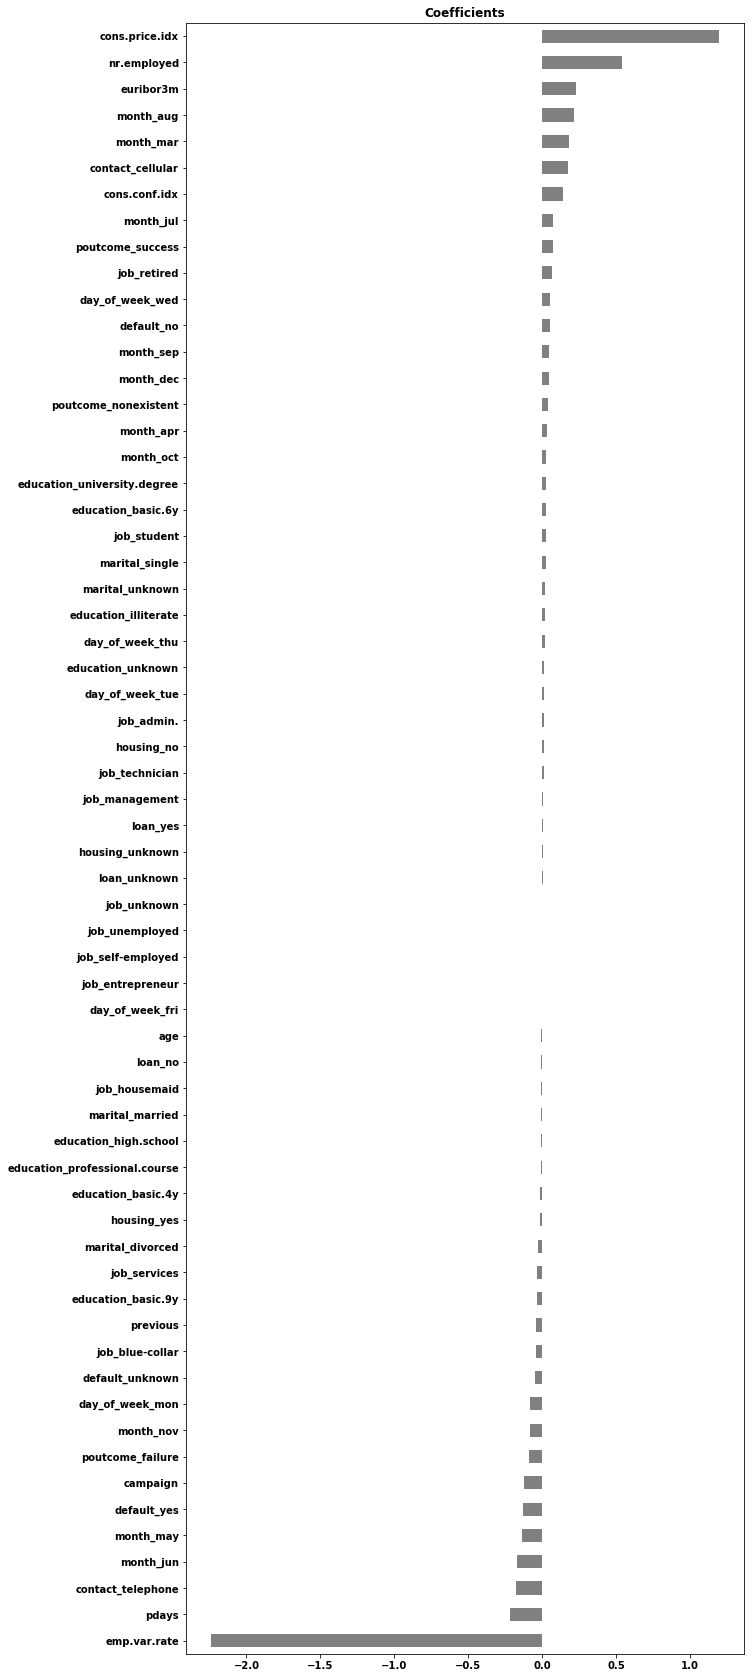

In [29]:
# (Re)fit on training data and plot coefficients
pipe.fit(X_train, y_train)

# Visualize coefficients
plt.figure(figsize=(10, 30))
plt.title('Coefficients')
coefficients = pipe.named_steps['logisticregression'].coef_[0]
feature_names = pipe.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');

### Improve the model

In [30]:
X_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [31]:
# Check for high cardinality features
cols = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']

for col in cols:
    counts = bank[col].nunique()
    print(counts, col)

78 age
12 job
4 marital
8 education
3 default
3 housing
3 loan
2 contact
10 month
5 day_of_week
42 campaign
27 pdays
8 previous
3 poutcome
10 emp.var.rate
26 cons.price.idx
26 cons.conf.idx
316 euribor3m
11 nr.employed


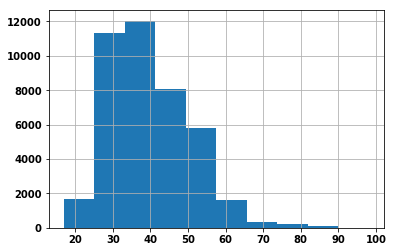

In [32]:
bank['age'].hist();

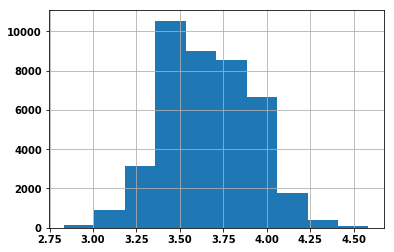

In [33]:
import numpy as np
bank['log_age'] = np.log(bank['age'])
bank['log_age'].hist();

In [38]:
# Dropping pdays feature due to large number of non-contacted customers
# bank = bank.drop(columns='pdays')

In [39]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,log_age
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,4.025352
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,4.043051
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3.610918
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,3.688879
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,4.025352


In [52]:
# Assign to X, y
X = bank.drop(columns='y')
y = bank['y'] == 'yes'

# Drop leaky duration feature
X = X.drop(columns='duration')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Cross-validation with train data
scores = cross_val_score(pipeline, X_train_encoded, y_train, scoring='roc_auc', cv=10, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished


In [54]:
# Print scores
print('Cross-Validation ROC AUC Scores:', scores)
print('Average:', scores.mean())

Cross-Validation ROC AUC Scores: [0.82101959 0.79370532 0.79071473 0.76452843 0.78519115 0.78919925
 0.76188648 0.79600923 0.80672527 0.77587458]
Average: 0.7884854027914827
